# Form to string

In [1]:
import pandas as pd

## Loading icebreakers_extract.csv as a pandas dataframe

In [2]:
df = pd.read_csv("./data/icebreakers_extract.csv")
df

,title,price,questions,advisor_id,deleted_at,user_skill_id,preview_media_url,icebreaker_type,allow_quantity,share_allowed_org,share_allowed_platform,description,locale,icebreaker_translations
0,Return Journey Planning - Eligibility & Legal ...,NaN,"[{""id"":92540555320,""body"":{""body"":""What is you...",1,NaN,2,NaN,1,0,0,0,This questionnaire helps NGO counselors assess...,en,3
1,Return Journey Planning - Eligibility & Legal ...,NaN,"[{""id"":81797796808,""body"":{""body"":""What is you...",1,NaN,2,NaN,1,0,0,0,This questionnaire helps NGO counselors assess...,en,3
2,Return Journey Planning - Eligibility & Legal ...,NaN,"[{""id"":38078152200,""body"":{""body"":""What is you...",1,NaN,2,NaN,1,0,0,0,This questionnaire helps NGO counselors assess...,en,3
3,Return Journey Planning - Eligibility & Legal ...,NaN,"[{""id"":35844159078,""body"":{""body"":""What is you...",1,NaN,8,NaN,1,0,0,0,This questionnaire helps NGO counselors assess...,en,3
4,Financial Recovery Aid Applications,NaN,"[{""id"":10699678759,""body"":{""body"":""What is you...",1,NaN,39,NaN,1,0,0,0,This questionnaire helps NGO counselors assess...,en,3


### Droping irrelevant columns¶

In [3]:
to_drop = ['advisor_id', 
           'deleted_at', 
           'user_skill_id', 
           'preview_media_url', 
           'icebreaker_type', 
           'allow_quantity', 
           'share_allowed_org', 
           'share_allowed_platform', 
           'locale', 
           'icebreaker_translations',
          'price']

df.drop(columns=to_drop, inplace=True)
df

,title,questions,description
0,Return Journey Planning - Eligibility & Legal ...,"[{""id"":92540555320,""body"":{""body"":""What is you...",This questionnaire helps NGO counselors assess...
1,Return Journey Planning - Eligibility & Legal ...,"[{""id"":81797796808,""body"":{""body"":""What is you...",This questionnaire helps NGO counselors assess...
2,Return Journey Planning - Eligibility & Legal ...,"[{""id"":38078152200,""body"":{""body"":""What is you...",This questionnaire helps NGO counselors assess...
3,Return Journey Planning - Eligibility & Legal ...,"[{""id"":35844159078,""body"":{""body"":""What is you...",This questionnaire helps NGO counselors assess...
4,Financial Recovery Aid Applications,"[{""id"":10699678759,""body"":{""body"":""What is you...",This questionnaire helps NGO counselors assess...


#### for a comparison of row 0 vs 1 vs 2 vs 3, kindly see `protoype_data_analysis_&_agent_development.ipynb` -> *initial comparison of question dicts*

Questions and answers are the same, ids etc can be d/f.

#### Form - Return Journey Planning - Eligibility & Legal Requirements

In [72]:
import json
import re

string_form = ""
question_number = 0
skip            = False
for i in json.loads(df['questions'][0]):
    question_number+=1
    current_string  = i['body']['body']

    if question_number>=18:
        current_string  = re.sub(r'\s*\(PII\)', '', current_string)
        current_list    = re.split(r'[:|]', current_string)
        current_list[0] = "Q" + str(question_number) + ": " + current_list[0] + ' (PII) ' + '?'
        skip            = True

    if skip == False:
        current_list    = re.split(r'[:|]', current_string)
        current_list[0] = "Q" + str(question_number) + ": " + current_list[0] + '?'
    for i,j in enumerate(current_list):
        if i!=0:
            # removing the first white space
            current_list[i] = current_list[i][1:]
            current_list[i] = str(i) + '. ' + current_list[i]
            
        string_form = string_form + current_list[i] + '\n'
        # print(current_list[i])
    string_form+='\n\n'
    # print()




In [79]:
# print(string_form)

In [74]:
# # Save to a text file
# with open("return_journey_planning_eligibility_nd_legal_requirements.txt", "w", encoding="utf-8") as f:
#     f.write(string_form)


In [ ]:
# Q6
# Abmeldung in Germany means deregistering your address when you move out or leave the country.
# You must inform the local office (Bürgeramt or Einwohnermeldeamt) that you no longer live at your German address.
# Afterward, you get a deregistration certificate, which helps you cancel contracts, insurance, or services.
# This should be done shortly before or within about two weeks after leaving your home in Germany.


In [1]:
# Load the .txt file as a string
with open("./data/return_journey_planning_eligibility_nd_legal_requirements.txt", "r", encoding="utf-8") as file:
    form_str = file.read()

# # Now text_data contains the whole file as a string
# print(text_data)  # Print first 500 characters to check


#### Form - 'Financial Recovery Aid Applications'

In [4]:
# import json
# import re

# string_form = ""
# question_number = 0
# skip            = False
# for i in json.loads(df['questions'][4]):
#     question_number+=1
#     current_string  = i['body']['body']

#     if question_number>=23:
#         current_string  = re.sub(r'\s*\(PII\)', '', current_string)
#         current_list    = re.split(r'[:|]', current_string)
#         current_list[0] = "Q" + str(question_number) + ": " + current_list[0] + ' (PII) ' + '?' + '\n' + '1.'
#         skip            = True

#     if skip == False:
#         current_list    = re.split(r'[:|]', current_string)
#         current_list[0] = "Q" + str(question_number) + ": " + current_list[0] + '?'
#     for i,j in enumerate(current_list):
#         if i!=0:
#             # removing the first white space
#             current_list[i] = current_list[i][1:]
#             current_list[i] = str(i) + '. ' + current_list[i]
            
#         string_form = string_form + current_list[i] + '\n'
#         # print(current_list[i])
#     string_form+='\n\n'
#     # print()




In [81]:
# print(string_form)

In [69]:
# # Save to a text file
# with open("financial_recovery_aid_applications.txt", "w", encoding="utf-8") as f:
#     f.write(string_form)


# Agent Development

In [40]:
from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Optional
from pydantic import Field


# from core import get_model, settings

import os
from dotenv import load_dotenv
load_dotenv()

# Access API keys and credentials
OPENAI_API_KEY    = os.environ["OPENAI_API_KEY"]
GEMINI_API_KEY    = os.environ["GEMINI_API_KEY"]
# TIMESCALE_DB_URI  = os.environ["TIMESCALE_DB_URI"]
# MAIN_AGENT_DB_URI = os.environ["MAIN_AGENT_DB_URI"]
# TAVILY_API_KEY    = os.environ["TAVILY_API_KEY"]


class AgentState(MessagesState):
    """
    Main state for the LangGraph.

    Inherits the ``messages`` key from ``MessagesState`` (the conversation history).

    Attributes
    ----------
    context_form : Optional[str]
        The STRING of the current form the user is filling out (from wcr.is),
        or None if no form is active.
    """
    context_form: Optional[str] = Field(
        default     = None,
        title       = "Context Form",
        description = (
            "Full STRING of the current form being filled by the user. "
            "Set to None when no form is active."
        ),
    )


    


MODEL_SYSTEM_MESSAGE = """
Your name is Refugee_Bridge. You are a kind, patient assistant for refugees using the wcr.is website.

The site has multiple forms.
The user chooses the form that matches their current need.
They fill out the form in another tab, not in this chat.
While completing it, they may ask you about words, legal terms, or any confusing part.
Your job is to guide them so they can finish the form correctly.

How to respond:
- IMPORTANT!: Always check the `Human Message`.
    - If it is written in a language other than English, reply in that same language.
    - If it is a mix of English and another language, reply in the non-English language.
- Be very polite and supportive.
- Use short sentences.
- Use simple, everyday English.
- Explain step by step.
- Focus on the exact question the user is stuck on.
- Give short examples when helpful.
- If you need details, ask one clear question at a time.
- Adjust your tone and explanation style to fit the person you’re talking to.
    - If the person is not well-educated, avoid technical terms. Use simple words and short sentences.
    - If the person seems to be in trauma, respond with care, love, and support. Focus on uplifting their spirit.
- Name of the form is given below. Always tell the user that you are currently helping with this form.

Current form:
<form>
{form_str}
</form>
"""
# - If someone asks a question in Ukrainian, Russian, or any other language, reply in the same language.


# form_str = 'null'




async def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    """Main model node:
       - Selects the concrete model (from config or default),
       - Runs the tool-enabled chat model,
       - Post-checks the output with LlamaGuard,
       - Enforces step budget if tool calls remain."""
    
    # # can later decide to pace it outside the fn, if observed high latency in traces
    # model      = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))
    # model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0, max_tokens=1000)

    # latency is way lower than openai
    model = ChatGoogleGenerativeAI(
        model       = "gemini-2.0-flash-lite",
        api_key     = GEMINI_API_KEY,          # make it of tyoe secret key when wrapping in fastapi
        temperature = 0,
        max_tokens  = 1000                      # stfg
    )

    
    system_msg = MODEL_SYSTEM_MESSAGE.format(form_str=config["configurable"]['form_str'])
    # print(system_msg)
    response   = await model.ainvoke(
                                        [SystemMessage(content=system_msg)] + state["messages"],
                                        config=config,
                                    )
    
    return {"messages": [response]}

# -------------------------
# BUILD THE GRAPH
# -------------------------

builder = StateGraph(AgentState)

builder.add_node("acall_model", acall_model)
builder.set_entry_point("acall_model")
builder.add_edge('acall_model', END)

# Compile with an in-memory checkpointer; resume by calling invoke() on the same thread_id
checkpointer = MemorySaver()

# Compile the graph with persistent checkpointer and in-memory store
graph = builder.compile(checkpointer=checkpointer)# store=across_thread_memory)

    

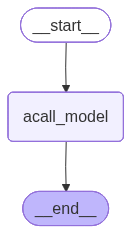

In [41]:
from IPython.display import Image, display
# View
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print(graph.get_graph().draw_ascii(), '\n\n')
    print(graph.get_graph().draw_mermaid())


In [43]:
import uuid


config = {
    "configurable": {
        "user_id":'Frank',
        "thread_id": '1',# str(uuid.uuid4()),
        "form_str": form_str,
    }
}

# 'что такое амбельдунг?'

text=HumanMessage(content='Hi!')
# Kick off (provide initial state once)
output = await graph.ainvoke({"messages": [text]}, config=config)
for msg in output['messages']:
    msg.pretty_print()


================================ Human Message =================================

need help with question 7?
================================== Ai Message ==================================

I am here to help you with the form "Return Journey Planning Eligibility And Legal Requirements".

You are asking about question 7.

It asks: "Which region of Ukraine do you plan to return to?"

You can choose one of these options:
1.  Western regions
2.  Central regions
3.  Eastern regions
4.  Southern regions
5.  Multiple regions
6.  Haven't decided
7.  Region is currently not accessible

Which option is best for you?
